## Access CPI input data series api.bls.gov, as well as build various DataFrames relating to CPI weights information

In [22]:
%matplotlib inline
import pandas as pd
import sys,os
import importlib
from math import log
import json, requests,lxml.html
import numpy as np
import datetime
import traceback
import pdb

### Set up URL and registration key for  accessing data from `api.bls.gov`

In [2]:
bls_base_url = 'https://api.bls.gov/publicAPI/v2'
headers = {'Content-type': 'application/json'}
reg_key = open('./temp_folder/bls_reg_key.txt','r').read()

### Get all surveys from BLS and save them in `df_all_surveys.csv`

In [3]:
dict_surveys = json.loads(requests.get(f'{bls_base_url}/surveys').text)
df_all_surveys = pd.DataFrame(dict_surveys['Results']['survey'])
df_all_surveys.to_csv('df_all_surveys.csv',index=False)

In [4]:
df_all_surveys

,survey_abbreviation,survey_name
0,AP,Consumer Price Index - Average Price Data
1,BD,Business Employment Dynamics
2,BG,Collective Bargaining Agreements-State and Loc...
3,BP,Collective Bargaining Agreements-Private Sector
4,CC,Employer Costs for Employee Compensation
...,...,...
61,TU,American Time Use
62,WD,Producer Price Index Commodity-Discontinued Se...
63,WM,Wage Modeling
64,WP,Producer Price Index-Commodities


### Retrieve the AP survey for Average Price Data

In [5]:
dict_surveys = json.loads(requests.get(f'{bls_base_url}/surveys/AP').text)
pd.DataFrame(dict_surveys['Results']['survey'])

,survey_name,survey_abbreviation,allowsNetChange,allowsPercentChange,hasAnnualAverages
0,Consumer Price Index - Average Price Data,AP,true,true,false


### Retreive multiple BLS series data using the v2 public api, with a registration key.

The `data` for the `post` to **api.bls.gov** contains a `seriesid` tag.  The object for this tag is a list of `seriesid` strings, such as `['CUUR0000SA0']` in the example below.

### Show an example of using api.bls.gov to get historical cpi values (seriesID  = CUUR0000SA0)

/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='yyyymm'>

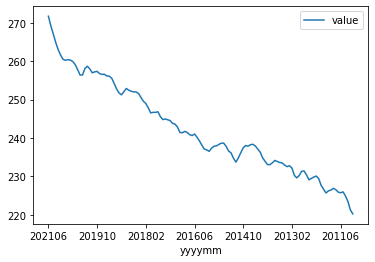

In [6]:
u = f'{bls_base_url}/timeseries/data/'
data = json.dumps({"seriesid": ['CUUR0000SA0'],"startyear":"2011", "endyear":"2021","registrationkey":reg_key})

p = requests.post(u, data=data, headers=headers)
json_data = json.loads(p.text)
df_temp = pd.DataFrame(json_data['Results']['series'][0]['data'])
df_temp['yyyymm'] = df_temp.year.astype(str) + df_temp.period.str.slice(1,3)
df_temp.sort_values('yyyymm')
df_temp['value'] = df_temp['value'].astype(float)
df_temp.plot(x='yyyymm',y='value')

#### Get all codes for the us cities datasets (AP0000).  There are 160 datasets.

In [7]:
# df_codes_us_cities = pd.DataFrame({'code':codes_us_cities}).to_csv('df_codes_us_cities.csv',index=False)

In [8]:
codes_us_cities = pd.read_csv('df_codes_us_cities.csv').code.values.tolist()

#### The dictionary `all_batch_dfs`  holds DataFrames if you decide to not fetch all 160 codes in one call

In [9]:
all_batch_dfs = []

In [10]:
len(codes_us_cities)

92

In [11]:
codes_us_cities

['APU0000701111',
 'APU0000701312',
 'APU0000701322',
 'APU0000702111',
 'APU0000702212',
 'APU0000702421',
 'APU0000703111',
 'APU0000703112',
 'APU0000703113',
 'APU0000703213',
 'APU0000703311',
 'APU0000703432',
 'APU0000703511',
 'APU0000703613',
 'APU0000704111',
 'APU0000704211',
 'APU0000704212',
 'APU0000704312',
 'APU0000705121',
 'APU0000706111',
 'APU0000706212',
 'APU0000706311',
 'APU0000708111',
 'APU0000709112',
 'APU0000710211',
 'APU0000710212',
 'APU0000710411',
 'APU0000711211',
 'APU0000711311',
 'APU0000711411',
 'APU0000711412',
 'APU0000711415',
 'APU0000711417',
 'APU0000712112',
 'APU0000712211',
 'APU0000712311',
 'APU0000712406',
 'APU0000712412',
 'APU0000713111',
 'APU0000714233',
 'APU0000715211',
 'APU0000716116',
 'APU0000717311',
 'APU0000718311',
 'APU0000720111',
 'APU0000720311',
 'APU000072511',
 'APU000072610',
 'APU000072620',
 'APU000074714',
 'APU000074715',
 'APU000074716',
 'APU000074717',
 'APU00007471A',
 'APU0000FC1101',
 'APU0000FC2101',


### Methods to retrieve data for seriesid's from api.bls.gov

In [12]:
def get_bls_data(
    bls_codes,
    start_year=2011,
    end_year=None,
    batch_size=500,
    registration_key=reg_key
):
    ey = datetime.datetime.now().year if end_year is None else end_year
    num_codes = len(bls_codes)
    num_batches = num_codes // batch_size + (1 if num_codes % batch_size > 0 else 0)
    bls_base_url = 'https://api.bls.gov/publicAPI/v2'
    u = f'{bls_base_url}/timeseries/data/'
    df_all = pd.DataFrame
    
#     pdb.set_trace()
    for b in range(num_batches):
        first_code = b*batch_size
        num_codes = batch_size if ((first_code + batch_size) < num_codes) else num_codes - first_code
        code_list = bls_codes[first_code:first_code+num_codes]
        data = json.dumps(
            {
                "seriesid": code_list,"startyear": str(start_year), "endyear":str(ey),
                "registrationkey":registration_key,
            }
        )
        try:
            p = requests.post(u, data=data, headers=headers)
            json_data = json.loads(p.text)
            print(json_data['status'])
        except Exception as e:
            traceback.print_exc()
            continue
        df_batch_series = pd.DataFrame()
        # populate df_batch_series
        for s in json_data['Results']['series']:
            d = s['data']
            if len(d)<=0:
                print(f'no data: {s}')
                continue
            df_temp = pd.DataFrame(d)
            df_temp['yyyymm'] = df_temp.year.astype(str) + df_temp.period.str.slice(1,3)
            df_temp.sort_values('yyyymm')
            df_temp['value'] = df_temp['value'].replace(to_replace='-', method='ffill').values
            df_temp['value'] = df_temp['value'].astype(float)
            df_temp['sid'] = s['seriesID']
            df_batch_series = df_batch_series.append(df_temp,ignore_index=True)
        # append df_batch_series to the dictionary all_batch_dfs
        all_batch_dfs.append(df_batch_series)

    # populate df_complete    
    df_complete = pd.DataFrame()
    for dft in all_batch_dfs:
        df_complete = df_complete.append(dft,ignore_index=True)
    df_complete = df_complete.drop('footnotes',axis=1).drop_duplicates(ignore_index=True)    
    return df_complete


def create_bls_pivot(df_complete):
    '''
    make the data for each series id into a column
    '''
    df_piv = pd.pivot_table(df_complete[['sid','yyyymm','value']],index='yyyymm',columns='sid',values='value')
    df_piv.index.name=None
    df_piv.columns.name = None
    df_piv.index = [datetime.datetime(int(yyyymm[0:4]),int(yyyymm[4:6]),1) for yyyymm in df_piv.index]
    return df_piv
    

In [13]:
bls_codes_to_fetch = [s.strip() for s in open('./bls_codes.txt','r').readlines()]
len(bls_codes_to_fetch),bls_codes_to_fetch

(1508,
 ['APU0000701111',
  'APU0000701311',
  'APU0000701312',
  'APU0000701321',
  'APU0000701322',
  'APU0000702111',
  'APU0000702112',
  'APU0000702211',
  'APU0000702212',
  'APU0000702213',
  'APU0000702221',
  'APU0000702411',
  'APU0000702421',
  'APU0000702611',
  'APU0000703111',
  'APU0000703112',
  'APU0000703113',
  'APU0000703211',
  'APU0000703212',
  'APU0000703213',
  'APU0000703311',
  'APU0000703312',
  'APU0000703411',
  'APU0000703421',
  'APU0000703422',
  'APU0000703423',
  'APU0000703425',
  'APU0000703431',
  'APU0000703432',
  'APU0000703511',
  'APU0000703512',
  'APU0000703611',
  'APU0000703612',
  'APU0000703613',
  'APU0000704111',
  'APU0000704211',
  'APU0000704212',
  'APU0000704311',
  'APU0000704312',
  'APU0000704313',
  'APU0000704314',
  'APU0000704321',
  'APU0000704411',
  'APU0000704412',
  'APU0000704413',
  'APU0000704421',
  'APU0000705111',
  'APU0000705121',
  'APU0000705141',
  'APU0000705142',
  'APU0000706111',
  'APU0000706211',
  'AP

In [20]:
df_results = get_bls_data(bls_codes_to_fetch)

REQUEST_SUCCEEDED
no data: {'seriesID': 'APU0000701311', 'data': []}
no data: {'seriesID': 'APU0000701321', 'data': []}
no data: {'seriesID': 'APU0000702211', 'data': []}
no data: {'seriesID': 'APU0000702213', 'data': []}
no data: {'seriesID': 'APU0000702221', 'data': []}
no data: {'seriesID': 'APU0000702411', 'data': []}
no data: {'seriesID': 'APU0000702611', 'data': []}
no data: {'seriesID': 'APU0000703211', 'data': []}
no data: {'seriesID': 'APU0000703411', 'data': []}
no data: {'seriesID': 'APU0000703421', 'data': []}
no data: {'seriesID': 'APU0000703422', 'data': []}
no data: {'seriesID': 'APU0000703423', 'data': []}
no data: {'seriesID': 'APU0000703425', 'data': []}
no data: {'seriesID': 'APU0000703611', 'data': []}
no data: {'seriesID': 'APU0000704313', 'data': []}
no data: {'seriesID': 'APU0000704314', 'data': []}
no data: {'seriesID': 'APU0000704321', 'data': []}
no data: {'seriesID': 'APU0000704411', 'data': []}
no data: {'seriesID': 'APU0000704412', 'data': []}
no data: {'se

In [21]:
len(df_results),len(df_results.sid.unique())

(2732, 27)

In [22]:
df_results.sid.unique()

array(['APU0000701111', 'APU0000701312', 'APU0000701322', 'APU0000702111',
       'APU0000702112', 'APU0000702212', 'APU0000702421', 'APU0000703111',
       'APU0000703112', 'APU0000703113', 'APU0000703212', 'APU0000703213',
       'APU0000703311', 'APU0000703312', 'APU0000703431', 'APU0000703432',
       'APU0000703511', 'APU0000703512', 'APU0000703612', 'APU0000703613',
       'APU0000704111', 'APU0000704211', 'APU0000704212', 'APU0000704311',
       'APU0000704312', 'APU0000705111', 'APU0000705121'], dtype=object)

### Get BLS CU item codes and associated weight levels

In [14]:
def get_cu_items():
    cu_text = open('./cu.item.txt','r').readlines()
    cu_headers = cu_text[0].strip().split('\t')
    cu_items = [s.strip().split('\t') for s in cu_text[1:]]
    df_cu_items = pd.DataFrame(cu_items,columns=cu_headers)
    df_cu_items.sort_sequence = df_cu_items.sort_sequence.astype(int)
    df_cu_items.display_level = df_cu_items.display_level.astype(int)    
    return df_cu_items

In [15]:
get_cu_items()

,item_code,item_name,display_level,selectable,sort_sequence
0,AA0,All items - old base,0,T,2
1,AA0R,Purchasing power of the consumer dollar - old ...,0,T,399
2,SA0,All items,0,T,1
3,SA0E,Energy,1,T,374
4,SA0L1,All items less food,1,T,358
...,...,...,...,...,...
394,SS68023,Tax return preparation and other accounting fees,4,T,352
395,SSEA011,College textbooks,3,T,314
396,SSFV031A,Food at elementary and secondary schools,3,T,122
397,SSGE013,Infants' equipment,3,T,355


### Get BLS Weights for each main CPI group

### Use xpath to find a specific weight level.

* Each weight level is coded with a `<p class="subN">` html tag, where N is a level number from 1 to 6
* To find all level 1 weights from DataFrame in `list_df_bls_weights` above, you perform an xpath search for all `<p>` tags with the `class` attributethat level having the value `sub1`
  * Your xpath would be `//p[contains(@class,'sub1')]`

In [23]:
RETRIEVE_WEIGHTS = False
if RETRIEVE_WEIGHTS:
    weights_url = 'https://www.bls.gov/cpi/tables/relative-importance/2020.htm'
    response = requests.get(weights_url)
    tree = lxml.html.fromstring(response.text)
    open('relative-importance_weights_2020.html','w').write(response.text)


#### Now do xpath search for `sub1` (level 01) rows of `df_bls_weights`

In [24]:
def get_bls_cu_df(level=None,merge_how='inner'):
    html_text = open('relative-importance_weights_2020.html','r').read()
    tree = lxml.html.fromstring(html_text) 
    p_class = f'sub{"" if level is None else level}'
    t = f"//p[contains(@class,'{p_class}')]"
    title_elem = tree.xpath(t)[0]
    sub_arr = tree.xpath(t)
    lev_names = [s.text for s in sub_arr]
    df_bls_weights = pd.read_html(html_text)[0]
    df_bls_weights.columns = df_bls_weights.columns.get_level_values(1)
    if level is None:
        df_bls_weights_lev = df_bls_weights.copy()
    else:
        df_bls_weights_lev = df_bls_weights[df_bls_weights['Item and Group'].isin(lev_names)]
    df_bls_weights_lev.index = range(len(df_bls_weights_lev))
    df_bls_weights_lev = df_bls_weights_lev.rename(
        columns={
            'Item and Group':'item_name',
            'CPI-U':'cpiu',
            'CPI-W':'cpiw',
        }
    )
    df_cu_items = get_cu_items()
    df_cu_items = df_cu_items.merge(df_bls_weights_lev,on='item_name',how=merge_how)
    df_cu_items = df_cu_items.drop_duplicates().sort_values('sort_sequence')
    df_cu_items.index = range(len(df_cu_items))
    df_cu_items['upper_sort_sequence'] = df_cu_items.sort_sequence.shift(-1)-1
    df_cu_items.upper_sort_sequence = df_cu_items.upper_sort_sequence.fillna(1000)
    return df_cu_items


In [25]:
def get_bls_cu_df_with_parent(parent_level):
    df_bls_lev_01 = get_bls_cu_df(parent_level)
    df_bls_lev_02 = get_bls_cu_df(parent_level+1)
    parent_ss_array = [
        df_bls_lev_01[
            (df_bls_lev_01.sort_sequence<s) & ((df_bls_lev_01.upper_sort_sequence>s))
        ].sort_sequence.values
        for s in df_bls_lev_02.sort_sequence.values
    ]
    parent_ss_array = [a[0] if len(a)==1 else None for a in parent_ss_array]
    df_bls_lev_02['parent'] = parent_ss_array
    return df_bls_lev_02    

In [31]:
get_bls_cu_df_with_parent(0)

,item_code,item_name,display_level,selectable,sort_sequence,cpiu,cpiw,upper_sort_sequence,parent
0,SAF,Food and beverages,0,T,3,15.157,16.650,135.0,1
1,SAH,Housing,0,T,136,42.385,40.874,186.0,1
2,SAA,Apparel,0,T,187,2.663,2.996,209.0,1
3,SAT,Transportation,0,T,210,15.160,16.853,249.0,1
4,SAM,Medical care,0,T,250,8.870,7.594,268.0,1
5,SAR,Recreation,0,T,269,5.797,5.223,310.0,1
6,SAE,Education and communication,0,T,311,6.810,6.557,334.0,1
7,SAG,Other goods and services,0,T,335,3.159,3.253,355.0,1
8,SA0L5,All items less medical care,1,T,356,91.130,92.406,356.0,1
9,SA0LE,All items less energy,1,T,357,93.845,92.636,357.0,1


In [26]:
get_bls_cu_df_with_parent(1)

,item_code,item_name,display_level,selectable,sort_sequence,cpiu,cpiw,upper_sort_sequence,parent
0,SAF1,Food,1,T,4,14.119,15.731,136.0,3.0
1,SAH1,Shelter,1,T,137,33.316,31.506,144.0,136.0
2,SAH2,Fuels and utilities,1,T,145,4.387,4.888,155.0,136.0
3,SAH3,Household furnishings and operations,1,T,156,4.682,4.481,187.0,136.0
4,SAA1,Men's and boys' apparel,1,T,188,0.666,0.770,194.0,187.0
5,SAA2,Women's and girls' apparel,1,T,195,1.075,1.106,201.0,187.0
6,SEAE,Footwear,1,T,202,0.644,0.844,205.0,187.0
7,SEAF,Infants' and toddlers' apparel,1,T,206,0.125,0.150,206.0,187.0
8,SEAG,Jewelry and watches,1,T,207,0.153,0.126,210.0,187.0
9,SAT1,Private transportation,1,T,211,14.055,16.043,241.0,210.0


In [27]:
def get_cu_bls_parent_children(parent_level):   
    df_bls_cu_wp_01 = get_bls_cu_df_with_parent(parent_level)
    df_bls_cu_parent_child_01 = pd.DataFrame(
        df_bls_cu_wp_01[
            ['parent','sort_sequence']
        ].groupby('parent',as_index=False).apply(
            lambda df:pd.Series(
                {
                    int(df.parent.values[0]):df.sort_sequence.values
                }
            )
        )
    )
    df_bls_cu_parent_child_01.columns = ['children']

    df_bls_cu_parent_child_01['parent'] = [
        v[1] for v in df_bls_cu_parent_child_01.index.values
    ]
    df_bls_cu_parent_child_01.index = range(len(df_bls_cu_parent_child_01))
    return df_bls_cu_parent_child_01

In [32]:
get_cu_bls_parent_children(1)

,children,parent
0,[4],3
1,"[137, 145, 156]",136
2,"[188, 195, 202, 206, 207]",187
3,"[211, 242]",210
4,"[251, 256]",250
5,"[270, 279, 286, 289, 296, 302, 308]",269
6,"[312, 320]",311
7,"[336, 339]",335
8,[367],366


In [33]:
get_cu_bls_parent_children(2)

,children,parent
0,"[5, 118, 125]",4
1,"[138, 139, 142]",137
2,"[146, 153]",145
3,"[157, 161, 166, 170, 175, 178, 182]",156
4,[189],188
5,[196],195
6,"[203, 204]",202
7,"[208, 209]",207
8,"[212, 221, 227, 232, 236, 237]",211
9,"[243, 244, 248]",242


In [34]:
df1 = get_cu_bls_parent_children(1)
df2 = get_cu_bls_parent_children(2)
grand_parents_df2 = []
for p in df2.parent.values:
    for r in df1.values:
        if p in r[0]:
            grand_parents_df2.append(r[1])
            break
df2['grand_parent'] = grand_parents_df2
df2

,children,parent,grand_parent
0,"[5, 118, 125]",4,3
1,"[138, 139, 142]",137,136
2,"[146, 153]",145,136
3,"[157, 161, 166, 170, 175, 178, 182]",156,136
4,[189],188,187
5,[196],195,187
6,"[203, 204]",202,187
7,"[208, 209]",207,187
8,"[212, 221, 227, 232, 236, 237]",211,210
9,"[243, 244, 248]",242,210
